In [10]:
import torch.nn as nn 
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
torch.manual_seed(42)

In [12]:
words=open("names.txt").read().splitlines()

In [13]:
chars=sorted(list(set("".join(words))))
stoi={s: i+1 for i,s in enumerate(chars)}
stoi['.']=0


itos={i:s for s,i in stoi.items()}
encode= lambda s : [stoi[c] for c in s] #-->int
decode=lambda i :  "".join([itos[x] for x in i  ])




In [40]:

block_size=8
def build_dataset(words) :
    X,Y=[],[]

    for w in words:
        context=[0] * block_size
        for ch in w+ '.' :
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join([itos[i] for i in context])," gives ","".join(itos[ix]))
            context=context[1:]+ [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182580, 8])
torch.Size([22767, 8])
torch.Size([22799, 8])


In [15]:
len(chars)

26

In [118]:

from typing import Any


class Linear :
    def __init__(self,fan_in,fan_out,bias=True) -> None:
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.randn((fan_out)) if bias else None
    
    def __call__(self,x) -> Any:
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self) :
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D :
    def __init__(self,dim,eps=1e-5, momentum=0.1 ) -> None:
        self.eps=eps
        self.dim=dim
        self.momentum=momentum
        self.is_training=True

        ##Scale and shift, learnable parameters using backprop
        self.gamma=torch.ones((self.dim))
        self.beta=torch.zeros((self.dim))

        ###Runnong mean and std
        self.running_mean=torch.zeros(dim)
        self.running_std=torch.ones(dim)
    
    def __call__(self,x) -> Any:
        if self.is_training :
            if x.ndim==2:
                dim=0
            elif x.ndim==3 :
                dim=(0,1) #because of the running mean else the first dimension won't be treated as a batch

            xmean=x.mean(dim,keepdim=True)
            xvar=x.var(dim,keepdim=True,unbiased=True)

        else :
                xmean=self.running_mean
                xvar=self.running_std
            
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps) 
        self.out=self.gamma*xhat + self.beta

        if self.is_training :
            with torch.no_grad() :

                self.running_mean=(1-self.momentum)*xmean + self.momentum*xmean
                self.running_std=(1-self.momentum)*xvar + self.momentum*xvar

        return self.out
    
    def parameters(self):
        return [self.gamma,self.beta]
    


class Tanh:

    def __call__(self,x) -> None:
        self.out= torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding :
    def __init__(self,num_emb,emb_dim) -> None:
        self.weight=torch.randn((num_emb,emb_dim))
    
    def __call__(self,X) :
        self.out=self.weight[X]
        
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class FlattenConsecutive :
    def __init__(self,n_elements) -> None:
        self.n=n_elements

    def __call__(self,x) :
        B,T,C=x.shape
        x=x.view(B,T//self.n,self.n*C)
        if x.shape[1]==1 :
            x=x.squeeze(1)
        self.out=x
        return self.out
    
    def parameters(self) :
        return []

class Sequential :

    def __init__(self,layers) -> None:
        self.layers=layers

    def __call__(self,x) -> Any:
        for layer in self.layers:
            x=layer(x)
        self.out=x
        return self.out
    
    def parameters(self):
        return  [p for layer in self.layers for p in layer.parameters()]

        
    
  


n_emb=24
n_consecutive=2
n_hidden=128
vocab_size=27
g=torch.Generator().manual_seed(2147483647)

model=Sequential([Embedding(vocab_size,n_emb),
                  FlattenConsecutive(n_consecutive),Linear(n_emb*n_consecutive,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
                  FlattenConsecutive(n_consecutive),Linear(n_hidden*n_consecutive,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
                  FlattenConsecutive(n_consecutive),Linear(n_hidden*n_consecutive,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
                  Linear(n_hidden,vocab_size),
]) 


with torch.no_grad() :
    #last layer make it less confident
    model.layers[-1].weight*=0.1
    for layer in model.layers[:-1] :
        if isinstance(layer,Linear) :
            layer.weight*=5/3


parameters = model.parameters()
for p in parameters :
     p.requires_grad=True
            


In [120]:
ix=torch.randint(0,Xtr.shape[0],(4,),generator=g)
Xb=Xtr[ix]
logits=model(Xb)

In [121]:
for layer in model.layers :
    print(layer.__class__.__name__, ':' , tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1D : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1D : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1D : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [111]:
batch_size=32
max_steps=20000
lossi=[]
stepi=[]
ud=[]


for i in range(max_steps) :

    #mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g )

    Xb,Yb=Xtr[ix],Ytr[ix]

    
    x=Xb
    x=model(Xb)
    
  
    loss=F.cross_entropy(x,Yb)
    for p in parameters :
        p.grad=None
    loss.backward()

    ##update

    # lr=lrs[i]
    lr=0.1 if i< 100000 else  0.01
    for p in parameters :
        p.data+=-lr*p.grad
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    with torch.no_grad() :
    
            ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])
    print(f"{i:7d}/{max_steps:7d} : {loss.item():4f}")


    

      0/  20000 : 3.589843
      1/  20000 : 3.337093
      2/  20000 : 3.205907
      3/  20000 : 3.280455
      4/  20000 : 3.518866
      5/  20000 : 3.055013
      6/  20000 : 3.321480
      7/  20000 : 3.218282
      8/  20000 : 3.084950
      9/  20000 : 3.206352
     10/  20000 : 3.016557
     11/  20000 : 2.614342
     12/  20000 : 3.295455
     13/  20000 : 2.831583
     14/  20000 : 3.073033
     15/  20000 : 2.695928
     16/  20000 : 3.282143
     17/  20000 : 3.042201
     18/  20000 : 2.674842
     19/  20000 : 3.420878
     20/  20000 : 3.580030
     21/  20000 : 2.740806
     22/  20000 : 2.819476
     23/  20000 : 2.570460
     24/  20000 : 2.978964
     25/  20000 : 2.953985
     26/  20000 : 3.195904
     27/  20000 : 3.056936
     28/  20000 : 2.893550
     29/  20000 : 2.749691
     30/  20000 : 2.924810
     31/  20000 : 2.811806
     32/  20000 : 2.694546
     33/  20000 : 2.721160
     34/  20000 : 3.142218
     35/  20000 : 3.020549
     36/  20000 : 2.868695
 

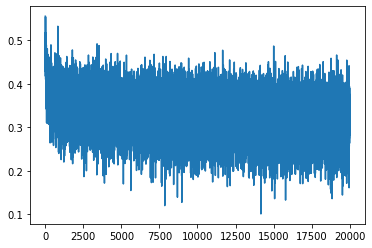

In [112]:
plt.plot(stepi,lossi)

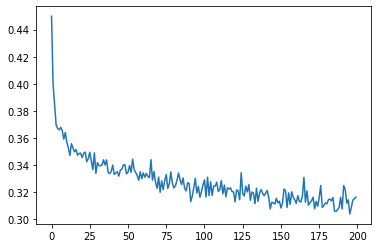

In [113]:
lossv=torch.tensor(lossi).view(-1,100).mean(1)
plt.plot(lossv)

In [114]:
for layer in model.layers :
    layer.is_training=False

In [115]:

@torch.no_grad() #disable gradient tracking
def split_loss(split):
    dict={'train' : (Xtr,Ytr),
         'val' : (Xdev,Ydev),
         'test':(Xte,Yte),}
    x,y=dict[split]
  
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())



In [116]:
split_loss("val")
split_loss("train")

val 2.1219875812530518
train 2.0637426376342773


In [117]:

for _ in range(20) :
    out=[]
    context=[0]*block_size
    while True :
        x=torch.tensor([context])
        logits=model(x)
        prob=F.softmax(logits,1)
        ix=torch.multinomial(prob,num_samples=1).item()
        context=context[1:] + [ix]
        out.append(ix)

        if ix==0 :
            break

    print("".join([itos[i] for i in out]))

adiley.
roperray.
kasilyn.
male.
lakynni.
miaxa.
paylin.
badee.
keilyn.
raelenn.
bruwa.
semmi.
dazianna.
behokanna.
kelinn.
dano.
kansie.
vielati.
jaarius.
joaquinze.
